# Question B3 (10 marks)

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [1]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

1.First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [2]:
# Load the dataset
df = pd.read_csv('hdb_price_prediction.csv')

# Dividing the dataset into train, validation and test sets by applying the given conditions
train_df = df[df['year'] <= 2019]  # Training data includes entries from year 2019 and before
validation_df = df[df['year'] == 2020]  # Validation data includes entries from year 2020
test_df = df[df['year'] == 2021]  # Test data includes entries from year 2021# YOUR CODE HERE

In [3]:
# Define the batch size
batch_size = 64

# Define the target columns
target = ['resale_price']

# Column type variables from the assignment pdf file
categorical_cols = ['year', 'month', 'town', 'full_address', 'nearest_stn', 'flat_model_type', 'storey_range']  # All categorical columns

# Dropping the categorical columns from the dataframes
train_df = train_df.drop(categorical_cols, axis=1)
validation_df = validation_df.drop(categorical_cols, axis=1)
test_df = test_df.drop(categorical_cols, axis=1)

# Getting the features (dropping the 'resale_price' target column)
X_train = train_df.drop(target, axis=1).values  # Training features
X_test = test_df.drop(target, axis=1).values  # Test features
X_validation = validation_df.drop(target, axis=1).values  # Validation features

# Getting the target labels
y_train = train_df[target].values  # Training target
y_test = test_df[target].values  # Test target
y_validation = validation_df[target].values  # Validation target

# Converting the features to tensors
X_train = torch.tensor(X_train, dtype=torch.float)  # Training features
X_test = torch.tensor(X_test, dtype=torch.float)  # Test features
X_validation = torch.tensor(X_validation, dtype=torch.float)  # Validation features

# Converting the target labels to tensors
y_train = torch.tensor(y_train, dtype=torch.float).view(-1, 1)  # Training target
y_test = torch.tensor(y_test, dtype=torch.float).view(-1, 1)  # Test target
y_validation = torch.tensor(y_validation, dtype=torch.float).view(-1, 1)  # Validation target

# Form the tensordatasets
train_t_dataset = torch.utils.data.TensorDataset(X_train, y_train)  # Training dataset
test_t_dataset = torch.utils.data.TensorDataset(X_test, y_test)  # Test dataset
validation_t_dataset = torch.utils.data.TensorDataset(X_validation, y_validation)  # Validation dataset

# Form the dataloaders
train_dataloader = torch.utils.data.DataLoader(train_t_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_t_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_t_dataset, batch_size=batch_size, shuffle=True)

2.Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [4]:
# Define the variables for the model
no_hidden = 5  # Number of neurons in the hidden layers
learning_rate = 0.001  # Learning rate for the optimizer
no_epochs = 100  # Number of epochs
no_features = X_train.shape[1]  # Number of features

# Define the model
class HDBPricePredictionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Defining the network architecture
            
            # Define the Input Layer --> 1st Hidden Layer
            nn.Linear(no_features, no_hidden),  # Linear layer with no_features input features and no_hidden output features
            nn.ReLU(),  # ReLU activation function
            
            # Define the 1st Hidden Layer --> 2nd Hidden Layer
            nn.Linear(no_hidden, no_hidden),  # Linear layer with no_hidden input features and no_hidden output features
            nn.ReLU(),  # ReLU activation function
            
            # Define the 2nd Hidden Layer --> 3rd Hidden Layer
            nn.Linear(no_hidden, no_hidden),  # Linear layer with no_hidden input features and no_hidden output features
            nn.ReLU(),  # ReLU activation function
            
            # Define the 3rd Hidden Layer --> Output Layer
            nn.Linear(no_hidden, 1)
        )

    def forward(self, x):
        return self.model(x)

In [5]:
# Initialize the model
model = HDBPricePredictionModel()

# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# Define the training function
def train(model, train_dataloader, loss_fn, optimizer, no_epochs):
    # Define the variable to store the training loss
    train_losses = []
    
    # Iterate through the epochs
    for epoch in range(no_epochs):
        # Set the model to training mode
        model.train()
        
        # Perform mini-batch gradient descent for the training dataset and compute the training accuracy and loss during the training process
        train_loss = 0  # Define the variable to store the training loss
        train_no_batches = len(train_dataloader)  # Define the number of mini-batches in the training dataset
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()  # Zero the gradients
            y_pred = model(X_batch)  # Perform a forward pass of the model
            loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
            loss.backward()  # Backpropagate the gradients
            optimizer.step()  # Update the model parameters
            
            # Compute the training accuracy and loss for the current batch
            train_loss += loss.item()  # Add the loss value to the running total
        
        # Compute the average training accuracy and loss values
        train_loss /= train_no_batches  # Compute the average training loss
        
        # Print the status for every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{no_epochs}, Training Loss: {train_loss:.4f}')
        
        train_losses.append(train_loss)  # Append the training loss to the list
    
    return train_losses # Return the list of training losses for each epoch

In [7]:
# Train the model
train_losses = train(model, train_dataloader, loss_fn, optimizer, no_epochs)

Epoch 10/100, Training Loss: 216351092494.5774
Epoch 20/100, Training Loss: 216342078512.0799
Epoch 30/100, Training Loss: 216329054377.8142
Epoch 40/100, Training Loss: 216321219896.0080
Epoch 50/100, Training Loss: 216309526253.8422
Epoch 60/100, Training Loss: 216303292706.5255
Epoch 70/100, Training Loss: 216294162579.3087
Epoch 80/100, Training Loss: 216282949736.3437
Epoch 90/100, Training Loss: 216274063077.6584
Epoch 100/100, Training Loss: 216268496134.9051


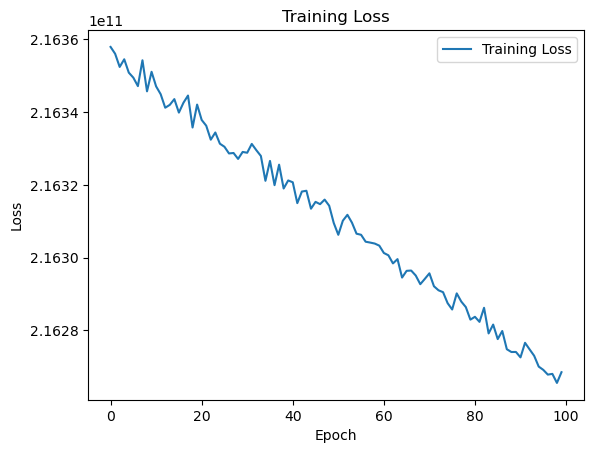

In [8]:
# Import the matplotlib library
import matplotlib.pyplot as plt

# Plot the training losses
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Import the sklearn.metrics library
import sklearn.metrics

# Set the model to evaluation mode
model.eval()

y_pred = model(X_test)  # Calculate the predictions for the test dataset

# Calculate the RMSE for the test dataset
rmse = sklearn.metrics.mean_squared_error(y_test.detach().numpy(), y_pred.detach().numpy(), squared=False)

# Print the RMSE for the test dataset
print(f'RMSE: {rmse:.4f}')

RMSE: 536560.6875


In [10]:
# Using only the first 1000 samples for the explanation to reduce the computation time

# Initialize a Saliency object for the given model to compute saliency maps, highlighting important pixels for predictions.
saliency = Saliency(model)
saliency_test = saliency.attribute(X_test[:1000])

# Initialize an InputXGradient object for the model to compute gradients of the output with respect to the input, illustrating how changes in inputs could affect predictions.
input_x_gradient = InputXGradient(model)
input_x_gradient_test = input_x_gradient.attribute(X_test[:1000])

# Initialize an IntegratedGradients object for the model to compute attributions by integrating gradients along the path from a baseline input to the actual input, offering a way to understand feature importance.
integrated_gradients = IntegratedGradients(model)
integrated_gradients_test = integrated_gradients.attribute(X_test[:1000], n_steps=50)

# Initialize a GradientShap object for the model to compute SHAP values using gradients,  combining ideas from SHAP (SHapley Additive exPlanations) with gradients for explanation.
gradient_shap = GradientShap(model)
gradient_shap_test = gradient_shap.attribute(X_test[:1000], X_train)

# Initialize a FeatureAblation object for the model to understand the impact of each feature on model predictions by systematically ablating (removing or masking) each feature and observing the effect.
feature_ablation = FeatureAblation(model)
feature_ablation_test = feature_ablation.attribute(X_test[:1000])

/opt/anaconda3/envs/sc4001_assignment/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


/var/folders/15/zxrjx0b91yngx3vx7r9sbq4h0000gn/T/ipykernel_79661/2876788566.py:7: RuntimeWarning: invalid value encountered in divide
  saliency_test_norm_sum = saliency_test_sum / np.linalg.norm(saliency_test_sum, ord=1)
/var/folders/15/zxrjx0b91yngx3vx7r9sbq4h0000gn/T/ipykernel_79661/2876788566.py:11: RuntimeWarning: invalid value encountered in divide
  input_x_gradient_test_norm_sum = input_x_gradient_test_sum / np.linalg.norm(input_x_gradient_test_sum, ord=1)
/var/folders/15/zxrjx0b91yngx3vx7r9sbq4h0000gn/T/ipykernel_79661/2876788566.py:19: RuntimeWarning: invalid value encountered in divide
  gradient_shap_test_norm_sum = gradient_shap_test_sum / np.linalg.norm(gradient_shap_test_sum, ord=1)


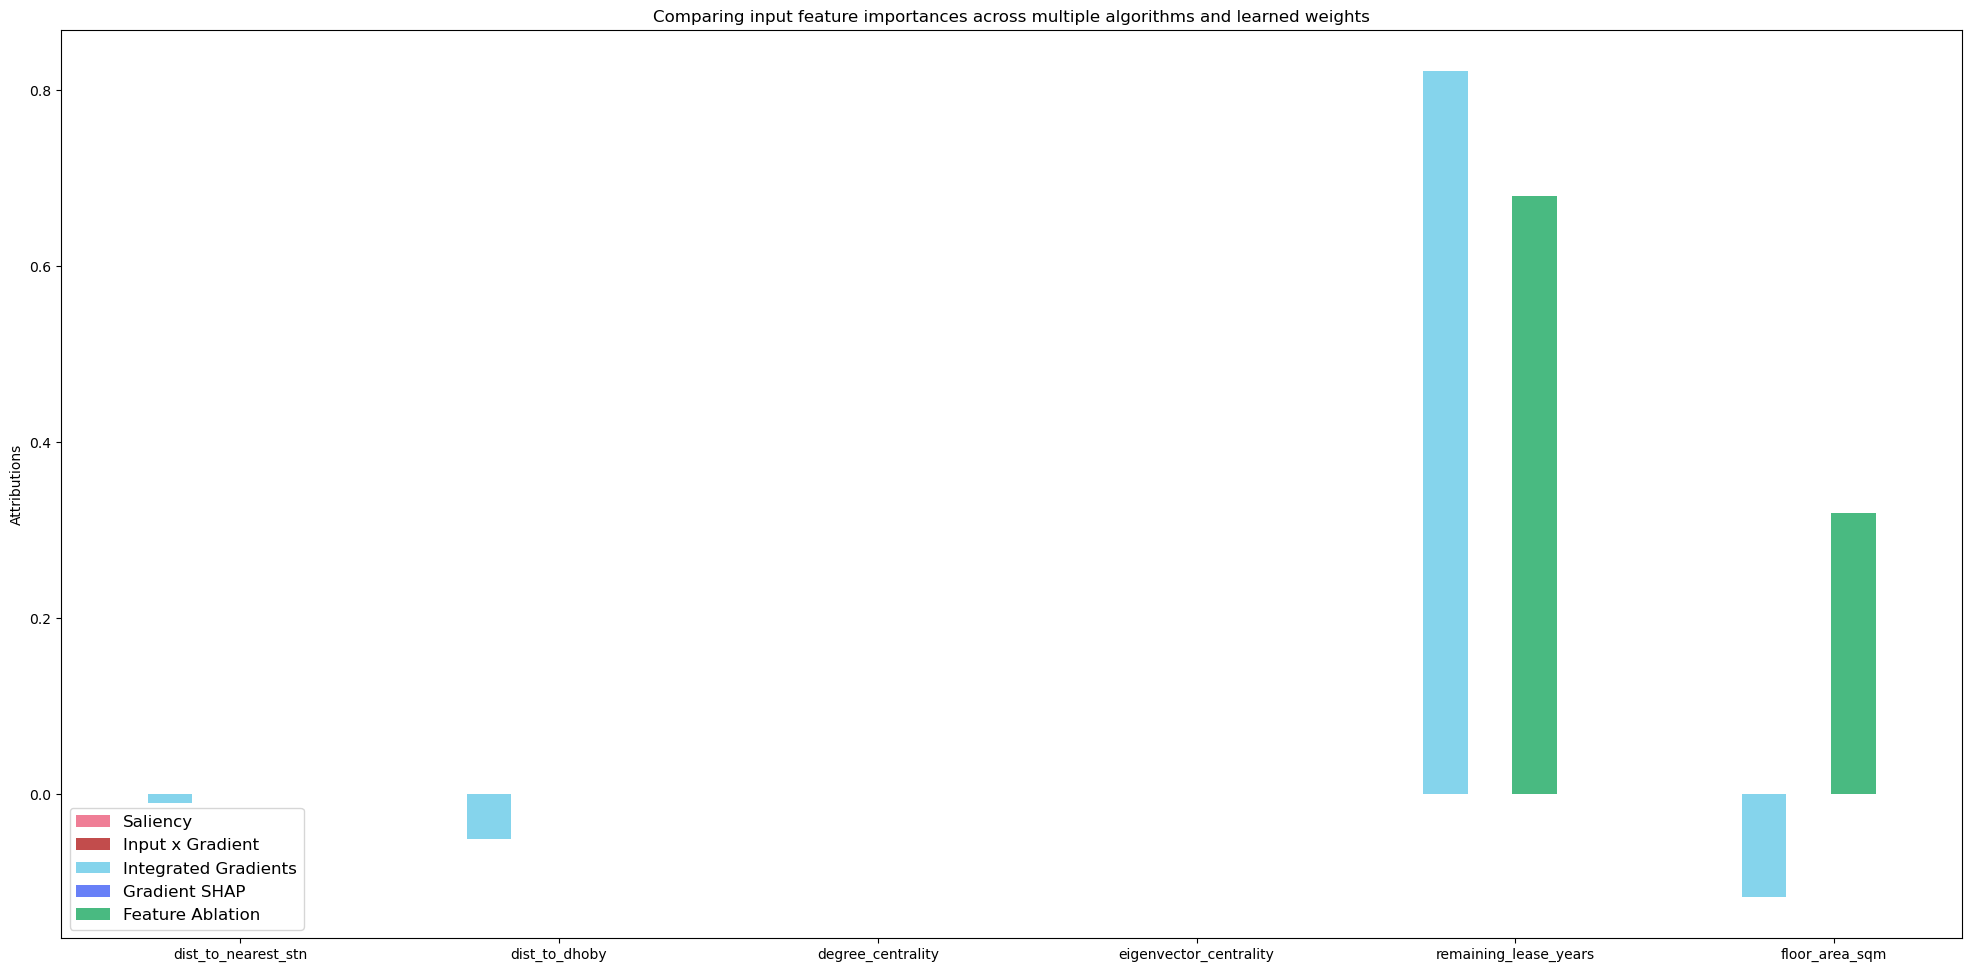

In [11]:
# Define the x-axis data and labels for the plot
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: train_df.drop(target, axis=1).columns[idx], x_axis_data))

# Prepare the saliency data
saliency_test_sum = saliency_test.detach().numpy().sum(0)
saliency_test_norm_sum = saliency_test_sum / np.linalg.norm(saliency_test_sum, ord=1)

# Prepare the input x gradient data
input_x_gradient_test_sum = input_x_gradient_test.detach().numpy().sum(0)
input_x_gradient_test_norm_sum = input_x_gradient_test_sum / np.linalg.norm(input_x_gradient_test_sum, ord=1)

# Prepare the integrated gradients data
integrated_gradients_test_sum = integrated_gradients_test.detach().numpy().sum(0)
integrated_gradients_test_norm_sum = integrated_gradients_test_sum / np.linalg.norm(integrated_gradients_test_sum, ord=1)

# Prepare the gradient shap data
gradient_shap_test_sum = gradient_shap_test.detach().numpy().sum(0)
gradient_shap_test_norm_sum = gradient_shap_test_sum / np.linalg.norm(gradient_shap_test_sum, ord=1)

# Prepare the feature ablation data
feature_ablation_test_sum = feature_ablation_test.detach().numpy().sum(0)
feature_ablation_test_norm_sum = feature_ablation_test_sum / np.linalg.norm(feature_ablation_test_sum, ord=1)

width = 0.14
legends = ['Saliency', 'Input x Gradient', 'Integrated Gradients', 'Gradient SHAP', 'Feature Ablation', 'Learned Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, saliency_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, input_x_gradient_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, integrated_gradients_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gradient_shap_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, feature_ablation_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()


3.Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [12]:
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training features and transform the training features
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test and validation features
X_test_scaled = scaler.transform(X_test)
X_validation_scaled = scaler.transform(X_validation)

# Convert the scaled features to tensors
X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float)  # Training features
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float)  # Test features
X_validation_scaled = torch.tensor(X_validation_scaled, dtype=torch.float)  # Validation features

# Define the tensordatasets
train_t_dataset_scaled = torch.utils.data.TensorDataset(X_train_scaled, y_train)  # Training dataset
test_t_dataset_scaled = torch.utils.data.TensorDataset(X_test_scaled, y_test)  # Test dataset
validation_t_dataset_scaled = torch.utils.data.TensorDataset(X_validation_scaled, y_validation)  # Validation dataset

# Define the dataloaders
train_dataloader_scaled = torch.utils.data.DataLoader(train_t_dataset_scaled, batch_size=batch_size, shuffle=True)
test_dataloader_scaled = torch.utils.data.DataLoader(test_t_dataset_scaled, batch_size=batch_size, shuffle=True)
validation_dataloader_scaled = torch.utils.data.DataLoader(validation_t_dataset_scaled, batch_size=batch_size, shuffle=True)

# Define the model
model_scaled = HDBPricePredictionModel()

# Define the optimizer
optimizer_scaled = torch.optim.Adam(model_scaled.parameters(), lr=learning_rate)

# Train the model
train_losses_scaled = train(model_scaled, train_dataloader_scaled, loss_fn, optimizer_scaled, no_epochs)

Epoch 10/100, Training Loss: 8959405997.1389
Epoch 20/100, Training Loss: 4207885999.1848
Epoch 30/100, Training Loss: 3819380616.3117
Epoch 40/100, Training Loss: 3689034139.3646
Epoch 50/100, Training Loss: 3568578991.5684
Epoch 60/100, Training Loss: 3511207919.6324
Epoch 70/100, Training Loss: 3439712281.8302
Epoch 80/100, Training Loss: 3364512715.0609
Epoch 90/100, Training Loss: 3316255799.1129
Epoch 100/100, Training Loss: 3290114188.1479


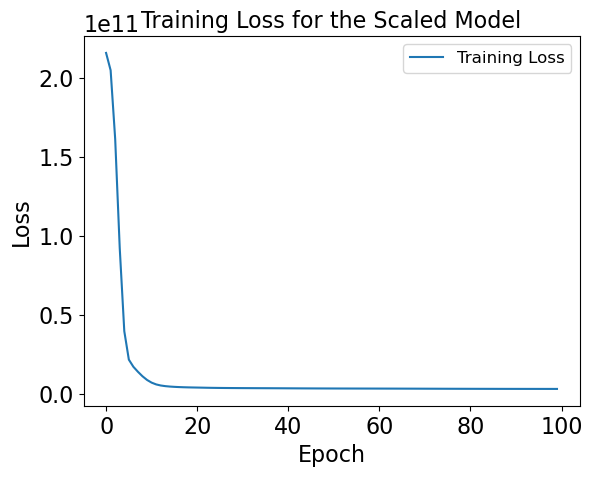

In [13]:
# Plot the training losses
plt.plot(train_losses_scaled, label='Training Loss')
plt.title('Training Loss for the Scaled Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Set the model to evaluation mode
model_scaled.eval()

y_pred_scaled = model_scaled(X_test_scaled)  # Calculate the predictions for the test dataset

# Calculate the RMSE for the test dataset
rmse_scaled = sklearn.metrics.mean_squared_error(y_test.detach().numpy(), y_pred_scaled.detach().numpy(), squared=False)

# Print the RMSE for the test dataset
print(f'RMSE: {rmse_scaled:.4f}')

RMSE: 89077.9688


In [15]:
# Using only the first 1000 samples for the explanation to reduce the computation time

# Initialize a Saliency object for the given model to compute saliency maps, highlighting important pixels for predictions.
saliency_scaled = Saliency(model_scaled)
saliency_test_scaled = saliency_scaled.attribute(X_test[:1000])

# Initialize an InputXGradient object for the model to compute gradients of the output with respect to the input, illustrating how changes in inputs could affect predictions.
input_x_gradient_scaled = InputXGradient(model_scaled)
input_x_gradient_test_scaled = input_x_gradient_scaled.attribute(X_test[:1000])

# Initialize an IntegratedGradients object for the model to compute attributions by integrating gradients along the path from a baseline input to the actual input, offering a way to understand feature importance.
integrated_gradients_scaled = IntegratedGradients(model_scaled)
integrated_gradients_test_scaled = integrated_gradients_scaled.attribute(X_test[:1000], n_steps=50)

# Initialize a GradientShap object for the model to compute SHAP values using gradients,  combining ideas from SHAP (SHapley Additive exPlanations) with gradients for explanation.
gradient_shap_scaled = GradientShap(model_scaled)
gradient_shap_test_scaled = gradient_shap_scaled.attribute(X_test[:1000], X_train_scaled)

# Initialize a GradientShap object for the model but with a different baseline - the unscaled training data
gradient_shap_test_scaled_unscaled_base = gradient_shap.attribute(X_test[:1000], X_train)

# Initialize a FeatureAblation object for the model to understand the impact of each feature on model predictions by systematically ablating (removing or masking) each feature and observing the effect.
feature_ablation_scaled = FeatureAblation(model_scaled)
feature_ablation_test_scaled = feature_ablation_scaled.attribute(X_test[:1000])

/opt/anaconda3/envs/sc4001_assignment/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


/var/folders/15/zxrjx0b91yngx3vx7r9sbq4h0000gn/T/ipykernel_79661/4081850295.py:19: RuntimeWarning: invalid value encountered in divide
  gradient_shap_test_norm_sum_scaled_unscaled_base = gradient_shap_test_sum_scaled_unscaled_base / np.linalg.norm(gradient_shap_test_sum_scaled_unscaled_base, ord=1)


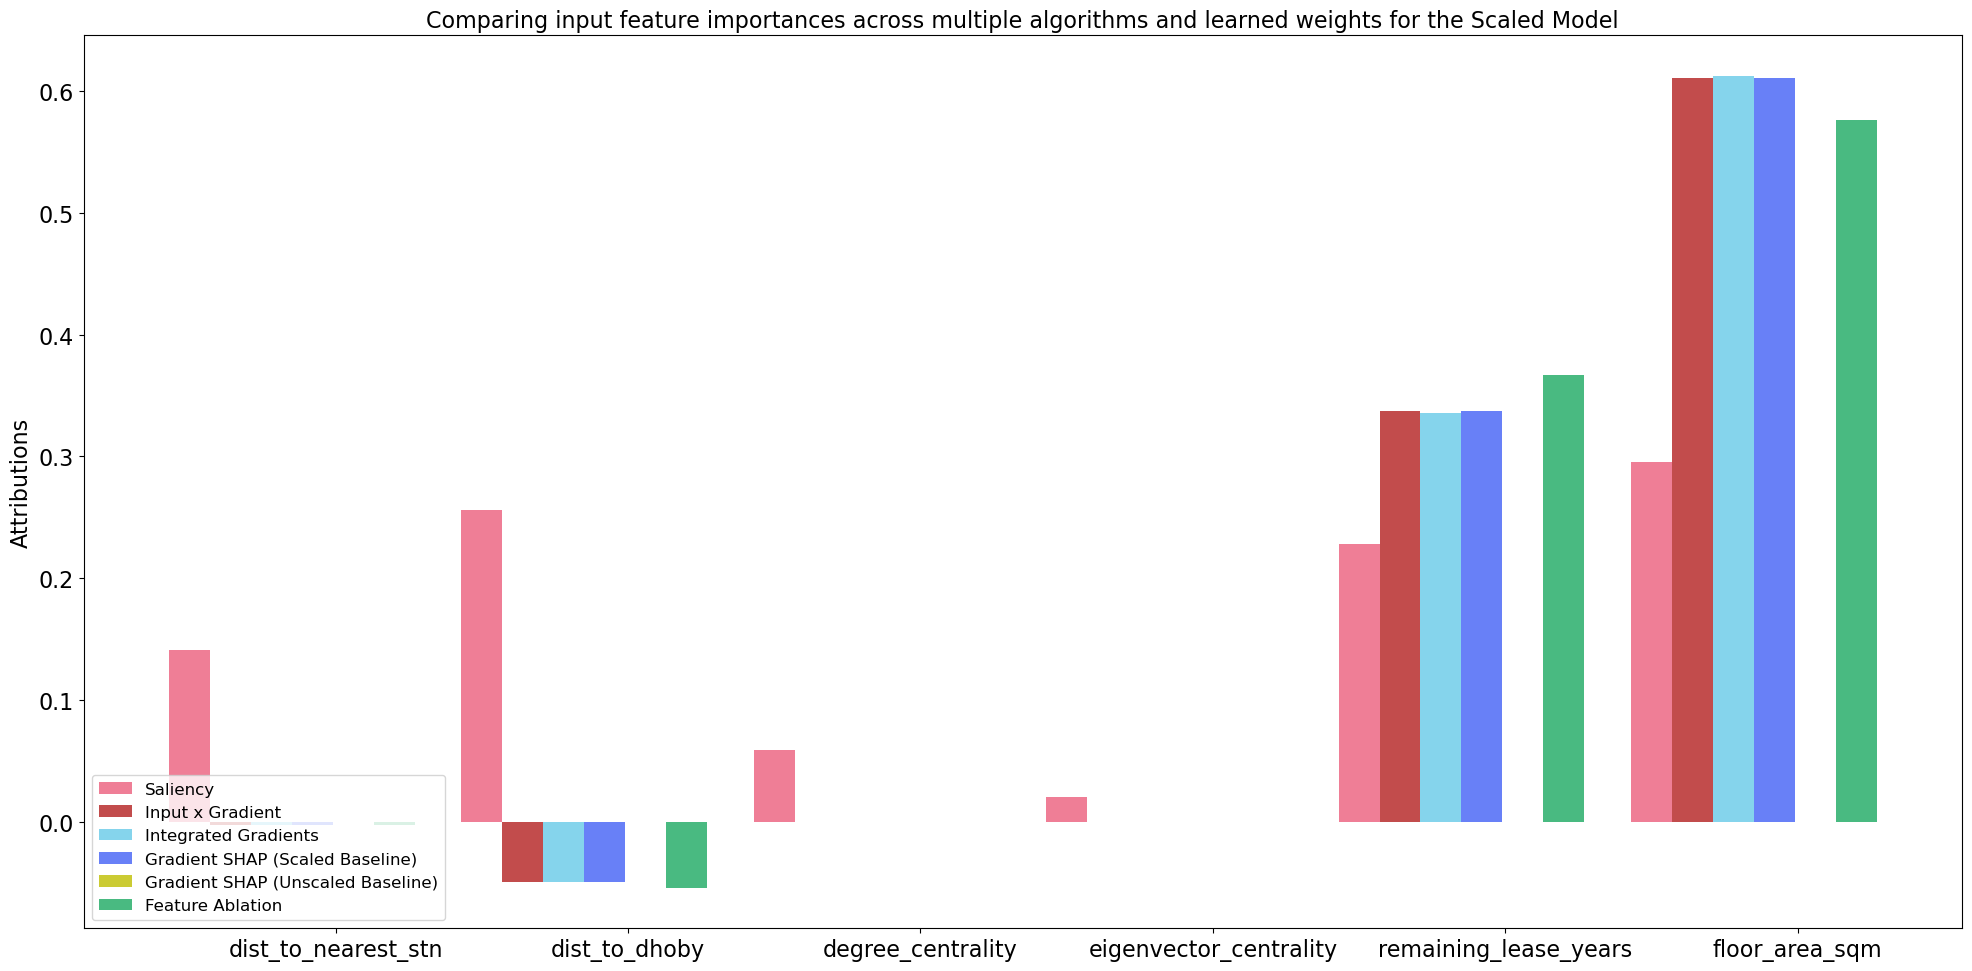

In [16]:
# Prepare the saliency data
saliency_test_sum_scaled = saliency_test_scaled.detach().numpy().sum(0)
saliency_test_norm_sum_scaled = saliency_test_sum_scaled / np.linalg.norm(saliency_test_sum_scaled, ord=1)

# Prepare the input x gradient data
input_x_gradient_test_sum_scaled = input_x_gradient_test_scaled.detach().numpy().sum(0)
input_x_gradient_test_norm_sum_scaled = input_x_gradient_test_sum_scaled / np.linalg.norm(input_x_gradient_test_sum_scaled, ord=1)

# Prepare the integrated gradients data
integrated_gradients_test_sum_scaled = integrated_gradients_test_scaled.detach().numpy().sum(0)
integrated_gradients_test_norm_sum_scaled = integrated_gradients_test_sum_scaled / np.linalg.norm(integrated_gradients_test_sum_scaled, ord=1)

# Prepare the gradient shap data
gradient_shap_test_sum_scaled = gradient_shap_test_scaled.detach().numpy().sum(0)
gradient_shap_test_norm_sum_scaled = gradient_shap_test_sum_scaled / np.linalg.norm(gradient_shap_test_sum_scaled, ord=1)

# Prepare the gradient shap data with the unscaled baseline
gradient_shap_test_sum_scaled_unscaled_base = gradient_shap_test_scaled_unscaled_base.detach().numpy().sum(0)
gradient_shap_test_norm_sum_scaled_unscaled_base = gradient_shap_test_sum_scaled_unscaled_base / np.linalg.norm(gradient_shap_test_sum_scaled_unscaled_base, ord=1)

# Prepare the feature ablation data
feature_ablation_test_sum_scaled = feature_ablation_test_scaled.detach().numpy().sum(0)
feature_ablation_test_norm_sum_scaled = feature_ablation_test_sum_scaled / np.linalg.norm(feature_ablation_test_sum_scaled, ord=1)

width = 0.14
legends = ['Saliency', 'Input x Gradient', 'Integrated Gradients', 'Gradient SHAP (Scaled Baseline)', 'Gradient SHAP (Unscaled Baseline)', 'Feature Ablation', 'Learned Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights for the Scaled Model')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, saliency_test_norm_sum_scaled, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, input_x_gradient_test_norm_sum_scaled, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, integrated_gradients_test_norm_sum_scaled, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gradient_shap_test_norm_sum_scaled, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, gradient_shap_test_norm_sum_scaled_unscaled_base, width, align='center',  alpha=0.8, color='y') # yellow
ax.bar(x_axis_data + 5 * width, feature_ablation_test_norm_sum_scaled, width, align='center', alpha=1.0, color='#49ba81')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

In [17]:
observation_grad_sh = """
The GradientSharp attributions for the scaled model are different from the unscaled one. This is because the GradientSharp algorithm uses a baseline to compute the attributions. The default baseline for the GradientSharp algorithm is the mean of the training data. When the features are scaled, the mean of the training data changes, which in turn changes the baseline for the GradientSharp algorithm. This results in different attributions for the scaled and unscaled models. In the scaled model, we have set the baseline to the scaled training data, which differs from the unscaled training data we have used for a baseline in the unscaled model. This is why the GradientSharp attributions for the scaled model are different from the unscaled one. If we change the baseline of the scaled model to the unscaled training data, the GradientSharp attributions for the scaled model will be similar to the unscaled one.
"""
print(f'Observation: {observation_grad_sh}')

Observation: 
The GradientSharp attributions for the scaled model are different from the unscaled one. This is because the GradientSharp algorithm uses a baseline to compute the attributions. The default baseline for the GradientSharp algorithm is the mean of the training data. When the features are scaled, the mean of the training data changes, which in turn changes the baseline for the GradientSharp algorithm. This results in different attributions for the scaled and unscaled models. In the scaled model, we have set the baseline to the scaled training data, which differs from the unscaled training data we have used for a baseline in the unscaled model. This is why the GradientSharp attributions for the scaled model are different from the unscaled one. If we change the baseline of the scaled model to the unscaled training data, the GradientSharp attributions for the scaled model will be similar to the unscaled one.



Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

4.Why did Saliency produce scores similar to IG?


In [18]:
observation_sal_ig = """
Generally, Saliency and Integrated Gradients (IG) both use gradient-based interpretability methods. They compute the importance of each input feature by measuring how changes in feature values affect the model's predictions. However, they do so in slightly different ways.

1. Saliency: Saliency computes the gradients of the output with respect to the input. It is a local method that computes the gradients of the output with respect to the input at the input data point. It is a simple and fast method that is used to highlight important pixels for predictions.

2. Integrated Gradients (IG): IG computes the attributions by integrating gradients along the path from a baseline input to the actual input. It is a global method that computes the gradients of the output with respect to the input at multiple points along the path from the baseline to the input. It is a more comprehensive method that provides a way to understand feature importance.

Both Saliency and IG can produce similar results when the relationship between the input features and the output prediction is mostly linear or the model behaves linearly in the vicinity of the input data. This is because the saliency method effectively captures the local gradient, and if that local gradient does not change much along the path to the baseline, then IG will effectively average the same values over the path, resulting in similar attributions.

However, in our context, the regression problem of predicting the HDB resale prices relies on a complex relationship between various input features. Thus, the problem may not be linear, and the relationship between the input features and the output prediction may not be captured well by the local gradients. This is why Saliency does not produced scores similar to IG in our context.

Scaling the features still does not change the difference between Saliency and IG because this difference is due to the nature of the two methods - path vs local (point-wise) computation of gradients.
"""
print(f'Observation: {observation_sal_ig}')

Observation: 
Generally, Saliency and Integrated Gradients (IG) both use gradient-based interpretability methods. They compute the importance of each input feature by measuring how changes in feature values affect the model's predictions. However, they do so in slightly different ways.

1. Saliency: Saliency computes the gradients of the output with respect to the input. It is a local method that computes the gradients of the output with respect to the input at the input data point. It is a simple and fast method that is used to highlight important pixels for predictions.

2. Integrated Gradients (IG): IG computes the attributions by integrating gradients along the path from a baseline input to the actual input. It is a global method that computes the gradients of the output with respect to the input at multiple points along the path from the baseline to the input. It is a more comprehensive method that provides a way to understand feature importance.

Both Saliency and IG can produce 

5.Why did Input x Gradients give the same attribution scores as IG?

In [19]:
observation_ixg_vs_ig = """
In classification tasks, neural networks often encounter the saturation problem, where certain neurons activate strongly for specific classes, leading to gradients that are near zero. This saturation can obscure the contribution of input features to the model's decision, making it challenging to interpret the model using direct gradients, as done in IxG. Integrated Gradients (IG) addresses this by integrating gradients along a path from a baseline to the actual input, potentially mitigating the impact of saturation by capturing the gradient information across a range of inputs.

However, in regression tasks, the output space is continuous, and the model's predictions are not constrained to discrete classes. This continuous nature reduces the likelihood of encountering saturation to the same extent as in classification tasks. Consequently, the gradients of the output with respect to the input (used in IxG) can remain informative and less prone to the near-zero gradients caused by saturation. Therefore, in regression contexts, the difference between computing the path integral of gradients (IG) and directly using gradients (IxG) might not be significant. The continuous output space allows for more gradual changes in predictions, making the direct gradients a reliable indicator of feature importance, similar to the integrated path of gradients in IG.

In our context, the HDB resale price prediction is a regression task, and the neural network's predictions are continuous. Therefore, the input x Gradients (IxG) and Integrated Gradients (IG) give similar attribution scores because the gradients of the output with respect to the input remain informative and less prone to saturation, making the difference between the two methods less significant.
"""
print(f'Observation: {observation_ixg_vs_ig}')


Observation: 
In classification tasks, neural networks often encounter the saturation problem, where certain neurons activate strongly for specific classes, leading to gradients that are near zero. This saturation can obscure the contribution of input features to the model's decision, making it challenging to interpret the model using direct gradients, as done in IxG. Integrated Gradients (IG) addresses this by integrating gradients along a path from a baseline to the actual input, potentially mitigating the impact of saturation by capturing the gradient information across a range of inputs.

However, in regression tasks, the output space is continuous, and the model's predictions are not constrained to discrete classes. This continuous nature reduces the likelihood of encountering saturation to the same extent as in classification tasks. Consequently, the gradients of the output with respect to the input (used in IxG) can remain informative and less prone to the near-zero gradients ca